# Setup

## Importing and testing Environment

In [71]:
import sys

print(sys.version)

3.8.16 (default, Jan 17 2023, 22:25:28) [MSC v.1916 64 bit (AMD64)]


In [72]:
import time

import os
import numpy as np
import pandas as pd

import tensorflow as tf 
from tensorflow import keras
#tf.config.set_per_process_memory_growth(True)

import pickle

import collections
from collections import defaultdict
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Embedding, Reshape, Activation
from keras.layers import Concatenate, Conv2DTranspose, multiply, UpSampling2D
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils import Progbar
from keras.metrics import *
from keras import backend as K

from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from skimage.transform import resize

import cv2

import visualkeras

# Data Loader

Check current dir

In [ ]:
os.getcwd()

'd:\\Projects\\chest-xrays-classification-generation'

Set batch size, image size and path

In [3]:
batch_size=64
img_size=112


# set training, validation, and testing paths
training_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/train')
val_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/val')
testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/test')

ImageDataGenerator:
- The directory must be set to the path where your ‘n’ classes of folders are present.
- The target_size is the size of your input images, every image will be resized to this size.
- color_mode: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.
- batch_size: No. of images to be yielded from the generator per batch.
- class_mode: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the output would probably be the same image, for this case set to “input”.
- shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False.
- seed: Random seed for applying random image augmentation and shuffling the order of the image.

In [4]:
# initialize training data generator with validation split and data augmentation
# train_datagen = ImageDataGenerator(validation_split = 0.1, 
#                                    shear_range=0.1, 
#                                    zoom_range=0.1)

train_datagen = ImageDataGenerator(shear_range=0.1, 
                                   zoom_range=0.1)

# initialize testing data generator with data augmentation
test_datagen = ImageDataGenerator(shear_range=0.1, 
                                  zoom_range=0.1)


In [ ]:

# generate training data from training path with batch size and target size specified
train_data = train_datagen.flow_from_directory(training_path, subset='training', 
                                               batch_size = batch_size, 
                                               target_size = (img_size, img_size),
                                               shuffle = True, class_mode = 'binary', seed = 42)

# generate validation data from training path with batch size and target size specified
val_data = train_datagen.flow_from_directory(training_path, subset='validation', 
                                             batch_size = batch_size, 
                                             target_size = (img_size, img_size), 
                                             shuffle = True, class_mode = 'binary', seed = 42) 

# train_data = train_datagen.flow_from_directory(training_path,
#                                                batch_size = batch_size, 
#                                                target_size = (img_size, img_size),
#                                                shuffle = True, class_mode = 'binary', seed = 41)

# generate testing data from testing path with batch size and target size specified
test_data = test_datagen.flow_from_directory(testing_path, batch_size = batch_size, 
                                             target_size = (img_size, img_size),
                                             shuffle = True, class_mode = 'binary', seed = 41)

# test_data_pneumonia = test_datagen.flow_from_directory(training_path, batch_size = batch_size, 
#                                              target_size = (img_size, img_size),
#                                              shuffle = True, class_mode = 'binary', 
#                                              seed = 41,
#                                              classes=['pneumonia'])

# print class indices for binary classification
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)


# get the first batch of training data

# batchX, batchy = train_data.next()

# print the shape of training batch and label batch
# print('train_batch.shape:', batchX.shape)
# print('label_batch.shape', batchy.shape)

In [5]:
len(train_data) # batches per epoch for training

460

In [4]:
# len(val_data) # batches per epoch for validation

In [5]:
len(test_data) # batches per epoch for testing

7

# Load Weights Only

## Define and initialize Generator

In [554]:
def generator(latent_dim = 100, n_classes = 3):
    # Initialize RandomNormal with mean = 0.0 and stddev = 0.02
    # init = RandomNormal(mean = 0.0, stddev = 0.02)
  
    ### Input 1: class label input ###
    
    # Generator take integer class label as input
    label_input = Input(shape = (1,))
    # print(label_input.shape)
    
    # Embedding layer: to convert class label integer to a vector of size 100
    y = Embedding(n_classes, 100)(label_input)
    # print('Embedding Layer: ', y.shape)
    
    # Dense layer with 7 x 7 units: to convert the vector to a 7 x 7 x 1 tensor
    n_nodes = 7 * 7
    y = Dense(n_nodes, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(y)
    # print('Dense 1: ', y.shape)
    y = Reshape((7, 7 ,1))(y)
    print('reshape(final y shape): ', y.shape)

    ### Input 2: generator noise input ###
    
    # A latent_dim-dimensional vector is sampled from a normal distribution
    # with mean = 0.0 and stddev = 0.02 
    generator_input = Input(shape = (latent_dim,))
    
    # Noise vector is passed through a dense layer with 1024 * 7 * 7 units 
    # to produce a 7 x 7 x 1024 tensor
    n_nodes = 1024 * 7 * 7
    gen = Dense(n_nodes, 
                kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(generator_input)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 1024))(gen)
    print('Generator noise input: ', gen.shape)
    
    ### Concatenate both the inputs ###
    # The output tensors are then concatenated to produce a 7 × 7 × 1025 tensor. 
    merge = Concatenate()([gen, y])
    print('Concatenate(generator noise input and y: ', merge.shape)

    ### Upsampling ###
    # four successive transposed convolutions 
    # to produce tensors with dimensions 14 × 14 × 512, 28 × 28 × 256, 56 × 56 × 128 and 128 × 128 × 3, respectively.
    
    # (None, 7, 7, 1024) --> (None, 14, 14, 512)
    gen = Conv2DTranspose(512, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(merge)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print("(None, 7, 7, 1024) -> (None, 14, 14, 512): ", gen.shape)

    # (None, 14, 14, 512)  --> (None, 28, 28, 256)
    gen = Conv2DTranspose(256, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 14, 14, 512) -> (None, 28, 28, 256): ', gen.shape)

    # (None, 28, 28, 256) --> (None, 56, 56, 128)
    gen = Conv2DTranspose(128, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 28, 28, 256) -> (None, 56, 56, 128): ', gen.shape)

    # (None, 56, 56, 128) --> (None, 112, 112, 3)
    gen = Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    out_layer = Activation("tanh")(gen)
    print("(None, 56, 56, 128) -> (None, 112, 112, 3): ", out_layer.shape)
    
    # The final output from the generator is an fake image X of dimension 112 × 112 × 3
    model = Model(inputs = [generator_input, label_input], outputs = out_layer)
    return model

In [555]:
generator_instance = generator(latent_dim = 100, n_classes = 3)
#generator_instance.summary()

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)


## Load weights and history

Importing picke objects containing training and testing history

In [74]:
current_epoch = 367
last_epoch = 388

History

In [75]:
path = f'./SaveDir/history/acgan_history_{last_epoch}.pkl'
hist = pickle.load(open(path, 'rb'))

Weights

In [578]:
filename = f"./SaveDir/best_weights/params_generator_epoch_{current_epoch}.hdf5"
generator_instance.load_weights(filename)

# Tools functions

In [47]:
# Function to generate a batch of noise and label 

def generate_batch_noise_and_labels_fixed(batch_size, latent_dim, gen_class = "normal"):
    name_map = {'COVID-19':0, 'normal':1, 'pneumonia':2}
    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # defined labels
    labels = np.full(batch_size, name_map[gen_class], dtype=int)

    return noise, labels

def generate_batch_noise_and_labels(batch_size, latent_dim, n_classes = 3):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # sample some labels
    sampled_labels = np.random.randint(0, n_classes, batch_size)

    return noise, sampled_labels

# Evaluation

## Visualize learning curve and Nash Equilibrium

In the context of Generative Adversarial Networks (GANs), the Nash Equilibrium refers to the point at which neither the generator nor the discriminator in the GAN can improve their performance by changing their strategy. The Nash Equilibrium is considered to be reached when the generator produces realistic images that are indistinguishable from real images, and the discriminator correctly classifies the generated images as fake with probability of 0.5.

At this equilibrium point, the generator is able to fool the discriminator into thinking that its fake images are real, while the discriminator is able to correctly identify the fake images as such. This results in a balance between the generator and discriminator, where neither is able to gain an advantage over the other by changing their approach. The Nash Equilibrium is an important concept in GAN training as it provides a means to evaluate the performance of a GAN and determine whether it has been trained effectively.

Visualize learning curves

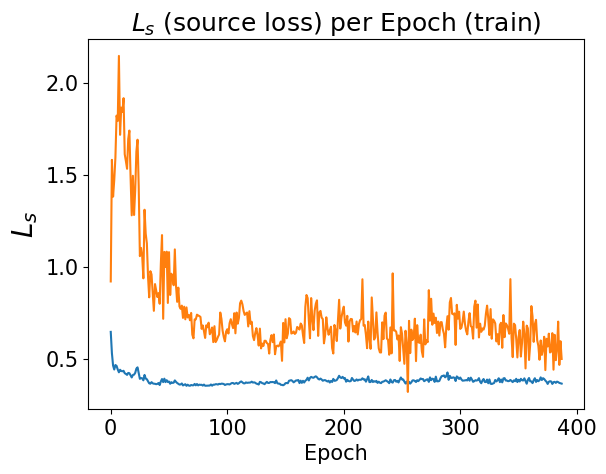

In [78]:
plt.rcParams["font.size"] = 15
for p in ['train']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['source_loss'], label='{} ({})'.format(g, p))        
        
# get the NE and show as an equilibrium point
#plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
# plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_s$ (source loss) per Epoch (train)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$', fontsize=20)
plt.show()

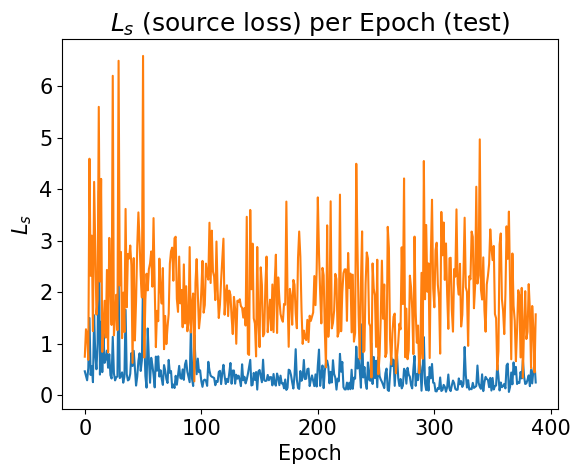

In [16]:
for p in ['test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['source_loss'], label='{} ({})'.format(g, p))        
        
# get the NE and show as an equilibrium point
#plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
#plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_s$ (source loss) per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')
plt.show()

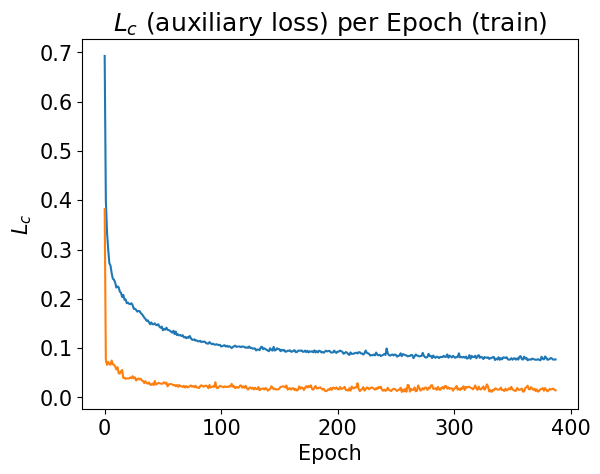

In [17]:
for p in ['train']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))        
        
# get the NE and show as an equilibrium point
#plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
#plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_c$ (auxiliary loss) per Epoch (train)')
#plt.title(r'$L_c$ (auxiliary classifier loss) per Epoch (train)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')
plt.show()

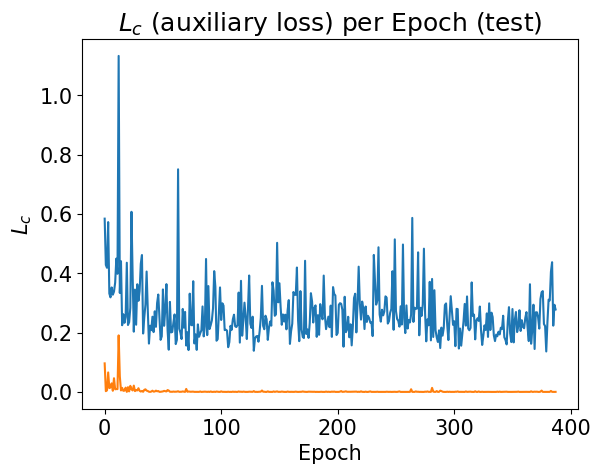

In [77]:
for p in ['test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))        
        
# get the NE and show as an equilibrium point
#plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
#plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_c$ (auxiliary loss) per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')
plt.show()

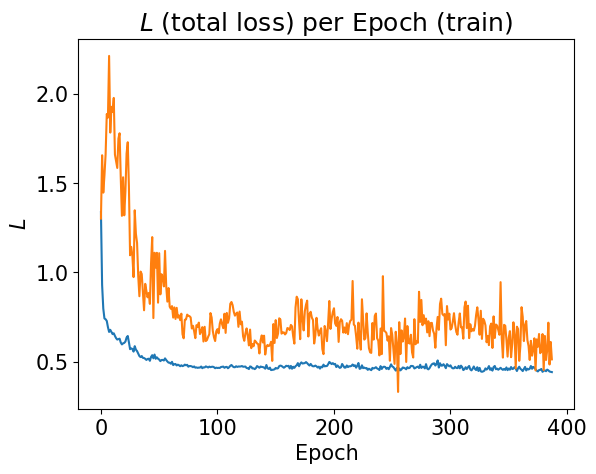

In [20]:
for p in ['train']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['loss'], label='{} ({})'.format(g, p))        
        
# get the NE and show as an equilibrium point
#plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
#plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L$ (total loss) per Epoch (train)')
plt.xlabel('Epoch')
plt.ylabel(r'$L$')
plt.show()

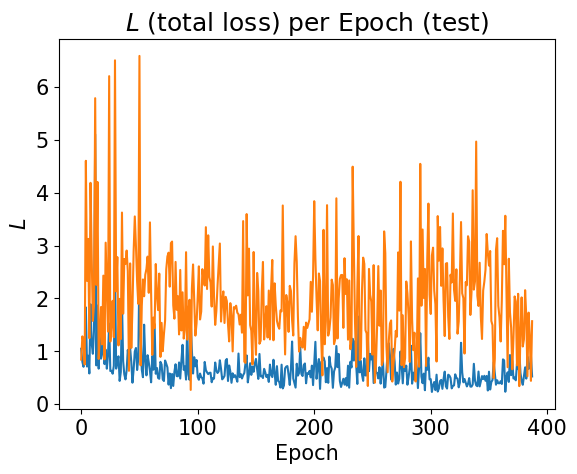

In [21]:
for p in ['test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['loss'], label='{} ({})'.format(g, p))        
        
# get the NE and show as an equilibrium point
#plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
#plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L$ (total loss) per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'$L$')
plt.show()

## Accuracy

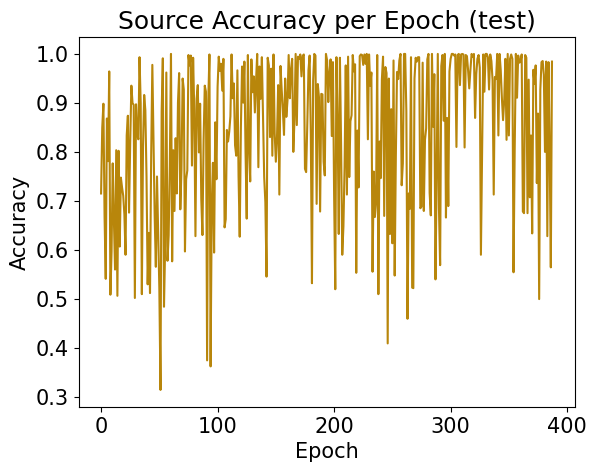

In [94]:
plt.rcParams["font.size"] = 15
plt.plot(np.mean([hist['accuracy']['discriminator_real'], hist[p]['discriminator_fake']], axis=0), label='discriminator (mean)', color = 'darkgoldenrod')

plt.title(r'Source Accuracy per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'Accuracy')
plt.show()

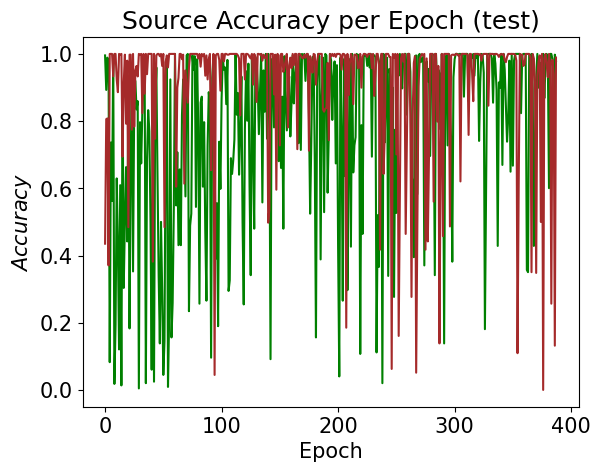

In [96]:
plt.rcParams["font.size"] = 15
colormap = ['green', 'brown']
for p in ['accuracy']:
    for i, g in enumerate(['discriminator_real', 'discriminator_fake']):
        plt.plot(hist[p][g], label='{} ({})'.format(g, p), color = colormap[i])
    # Create a vector point-by-mean of the two accuracies vectors 
    
#plt.legend(['Discriminator Real', 'Discriminator Fake'])
plt.title(r'Source Accuracy per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'$Accuracy$')
plt.show()

## FID Score

FID (Fréchet Inception Distance) is a metric that measures the distance between the distributions of two sets of images at feature level, one consisting of the real images and the other of the generated images. 

- The FID measures the **distance** between the **distributions** of the real and generated images,
- It also captures 
  1. **diversity** 
  2. **visual quality** 
  3. **consistency** with real images
- You want to minimise (The lower the FID value, the more similar the distribution of the generated images is to that of the real images).
- Capture: visual quality and sample diversity (partly also intra-conditioning diversity)
- Problem: like IS, visual quality and sample diversity are not divisible
- Amount of data needed: a lot of data is needed to compare the two distributions. [google/ddpm-cifar10-32 - FID Score (huggingface.co)](https://huggingface.co/google/ddpm-cifar10-32/discussions/10) (talks about 50k images)
    - In my code I therefore used a batch generator, which allows calculation on 30000 images

If the code from OOM error restarts the notebook every time one of the metrics is calculated.

In [41]:
def generate_batch_noise_and_labels_FID(batch_size, latent_dim, n_classes = 3):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # sample some labels
    sampled_labels = np.random.randint(0, n_classes, batch_size)

    return noise, sampled_labels

def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)

def predict_inception(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1, verbose = False)
    act2 = model.predict(images2, verbose = False)
    return act1, act2

# calculate frechet inception distance
def calculate_fid(act1, act2):
    print('Calculating FID')
    print('act1 shape: ', act1.shape)
    print('act2 shape: ', act2.shape)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    # print('FID: ', fid)
    return fid

def get_FID(generative_model, evaluation_model, 
            real_images_generator, n_classes=3, n_trials=10, batch_size=400):

    FID_array = np.zeros(n_trials)
    # real_scaled_images = cv2.normalize((real_scaled_images + 1) * 127.5, 
    #                                    None, alpha=0, beta=255, 
    #                                    norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    for i in range(n_trials):
        
        nb_batches = len(real_images_generator)
        
        progress_bar = Progbar(target=nb_batches)
        
        for index, (real_images, label_batch) in zip(range(nb_batches), real_images_generator):
            
            progress_bar.update(index+1) # update progress bar
            
            real_images = real_images / 255. # Scale from 0-255 to 0-1
            real_images = scale_images(real_images, (299,299,3))
            
            batch_size_real = real_images.shape[0] # ImageDataGenerator may not return a full batch
            seed_noise_rand, seed_labels_rand = generate_batch_noise_and_labels_FID(batch_size=batch_size_real, latent_dim=100)
            generated_images_sample = generative_model.predict([seed_noise_rand, seed_labels_rand.reshape((-1, 1))], verbose=0)
            # print(generated_images_sample[1])

            # if n_classes == 3:
            #     fake_images = generative_model.generator.predict([benchmarkNoise, benchmarkLabels])
            # else:
            #     fake_images = generative_model.generator.predict([benchmarkNoise])
            
            # fake_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(fake_images), name=None)
            
            generated_images_sample = (generated_images_sample + 1) / 2
            generated_images_sample = cv2.normalize(generated_images_sample, 
                                            None, alpha=0, beta=1, 
                                            norm_type=cv2.NORM_MINMAX, 
                                            dtype=cv2.CV_32F)
            generated_images_sample = scale_images(generated_images_sample, (299,299,3))

            #print("Real image min and max: ", np.min(real_images), np.max(real_images))
            #print("Fake image min and max: ", np.min(generated_images_sample), np.max(generated_images_sample))
            
            if index == 0: # first batch declares the shape of the arrays
                act1_vector, act2_vector = predict_inception(evaluation_model, real_images, generated_images_sample)
            
            else:
                act1, act2 = predict_inception(evaluation_model, real_images, generated_images_sample)
                act1_vector = np.concatenate((act1_vector, act1), axis=0)
                act2_vector = np.concatenate((act2_vector, act2), axis=0)
            
        fid = calculate_fid(act1_vector, act2_vector)
        FID_array[i] = fid
        print("Trial ", i)
        print("FID: ", fid)

    mean_FID = np.mean(FID_array)
    std_FID = np.std(FID_array)

    return mean_FID, std_FID

In [19]:
batch_size_FID = 64

Batch Version

In [12]:
FID_testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/train')

FID_testing_data = test_datagen.flow_from_directory(FID_testing_path, batch_size = batch_size_FID, 
                                             target_size = (img_size, img_size),
                                             shuffle = True, class_mode = 'binary', seed = 42)
#batchx, batchy = test_data.next()
# batchx = (batchx - 127.5)/127.5	# scale to [-1, 1]
#batchx = batchx / 255. # scale to [0, 1]

Found 29404 images belonging to 3 classes.


Load the Inception model

In [13]:
evaluation_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299,3))

Compute FID

In [ ]:
mean_FID_ACcGAN, std_FID_ACcGAN = get_FID(generative_model=generator_instance, 
                                          evaluation_model=evaluation_model, 
                                          real_images_generator=FID_testing_data, n_classes=3,
                                          batch_size=batch_size_FID,
                                          n_trials=2)
print("------- AC-GAN model -------")
print("Mean FID: ", mean_FID_ACcGAN)
print("STD FID: ", std_FID_ACcGAN)

## Intra-FID

Intra-FID calculates a FID score separately for each conditioning (class) and reports the average score over all conditionings.
- Captures: 
  1. visual **quality**
  2. **conditional consistency** and 
  3. **intra-condition diversity**
- You want to MINIMISE it
- How it is calculated: https://github.com/takuhirok/rGAN/issues/2
    - You take x images conditionally generated to class c
    - You take x images from the dataset related to class c
    - FID is calculated
    - Repeat for each class and average

If the code from OOM error restarts the notebook every time one of the metrics is calculated.

In [170]:
def generate_batch_noise_and_labels_intra_FID(batch_size, latent_dim, gen_class = "normal"):
    name_map = {'COVID-19':0, 'normal':1, 'pneumonia':2}
    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # defined labels
    labels = np.full(batch_size, name_map[gen_class], dtype=int)

    return noise, labels

def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)

def predict_inception(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1, verbose = False)
    act2 = model.predict(images2, verbose = False)
    return act1, act2

# calculate frechet inception distance
def calculate_fid(act1, act2):
    print('Calculating Intra-FID')
    print('act1 shape: ', act1.shape)
    print('act2 shape: ', act2.shape)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    # print('FID: ', fid)
    return fid

def get_intra_FID(generative_model, evaluation_model, 
            test_datagen,
            FID_testing_path, labels,
            n_classes=3, 
            batch_size_FID=64):
    

    FID_array = np.zeros(n_classes)
    # real_scaled_images = cv2.normalize((real_scaled_images + 1) * 127.5, 
    #                                    None, alpha=0, beta=255, 
    #                                    norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    for i, label in enumerate(labels):
        print("FID for class: ", label)
        
        Intra_FID_testing_data = test_datagen.flow_from_directory(FID_testing_path, 
                                                            batch_size = batch_size_FID, 
                                                            target_size = (img_size, img_size),
                                                            shuffle = True, 
                                                            class_mode = 'binary',
                                                            classes=[label], 
                                                            seed = 42)
        
        nb_batches = len(Intra_FID_testing_data)
        
        progress_bar = Progbar(target=nb_batches)
        
        for index, (real_images, label_batch) in zip(range(nb_batches), Intra_FID_testing_data):
            
            progress_bar.update(index+1) # update progress bar
            
            real_images = real_images / 255. # Scale from 0-255 to 0-1
            real_images = scale_images(real_images, (299,299,3))
            
            batch_size_real = real_images.shape[0] # ImageDataGenerator may not return a full batch
            seed_noise_rand, seed_labels_rand = generate_batch_noise_and_labels_intra_FID(batch_size=batch_size_real, 
                                                                                          latent_dim=100,
                                                                                          gen_class=label)
            generated_images_sample = generative_model.predict([seed_noise_rand, seed_labels_rand.reshape((-1, 1))], verbose=0)
            # print(generated_images_sample[1])

            # if n_classes == 3:
            #     fake_images = generative_model.generator.predict([benchmarkNoise, benchmarkLabels])
            # else:
            #     fake_images = generative_model.generator.predict([benchmarkNoise])
            
            # fake_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(fake_images), name=None)
            
            generated_images_sample = (generated_images_sample + 1) / 2
            generated_images_sample = cv2.normalize(generated_images_sample, 
                                            None, alpha=0, beta=1, 
                                            norm_type=cv2.NORM_MINMAX, 
                                            dtype=cv2.CV_32F)
            generated_images_sample = scale_images(generated_images_sample, (299,299,3))

            #print("Real image min and max: ", np.min(real_images), np.max(real_images))
            #print("Fake image min and max: ", np.min(generated_images_sample), np.max(generated_images_sample))
            
            if index == 0: # first batch declares the shape of the arrays
                act1_vector, act2_vector = predict_inception(evaluation_model, real_images, generated_images_sample)
            
            else:
                act1, act2 = predict_inception(evaluation_model, real_images, generated_images_sample)
                act1_vector = np.concatenate((act1_vector, act1), axis=0)
                act2_vector = np.concatenate((act2_vector, act2), axis=0)
            
        fid = calculate_fid(act1_vector, act2_vector)
        FID_array[i] = fid
        print("Class ", label)
        print("FID: ", fid)

    mean_FID = np.mean(FID_array)
    std_FID = np.std(FID_array)

    return mean_FID, std_FID

In [11]:
batch_size_FID = 64

Batch Version

In [12]:
FID_testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/train')

Load the Inception model

In [13]:
evaluation_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299,3))

Compute FID

In [14]:
mean_intra_FID_ACcGAN, std_intra_FID_ACcGAN = get_intra_FID(generative_model=generator_instance, 
                                                    evaluation_model=evaluation_model, 
                                                    n_classes=3,
                                                    batch_size_FID=batch_size_FID,
                                                    FID_testing_path = FID_testing_path,
                                                    labels = ['COVID-19', 'normal', 'pneumonia'],
                                                    test_datagen=test_datagen)
print("------- AC-GAN model Intra-FID -------")
print("Mean FID: ", mean_intra_FID_ACcGAN)
print("STD FID: ", std_intra_FID_ACcGAN)

FID for class:  COVID-19
Found 15774 images belonging to 1 classes.
247/247 [==============================] - 364s 1s/step
Calculating Intra-FID
act1 shape:  (15774, 2048)
act2 shape:  (15774, 2048)
Class  COVID-19
FID:  181.92933418289795
FID for class:  normal
Found 8085 images belonging to 1 classes.
127/127 [==============================] - 187s 1s/step
Calculating Intra-FID
act1 shape:  (8085, 2048)
act2 shape:  (8085, 2048)
Class  normal
FID:  107.13055745892976
FID for class:  pneumonia
Found 5545 images belonging to 1 classes.
87/87 [==============================] - 125s 1s/step
Calculating Intra-FID
act1 shape:  (5545, 2048)
act2 shape:  (5545, 2048)
Class  pneumonia
FID:  128.73206823441436
------- AC-GAN model Intra-FID -------
Mean FID:  139.263986625414
STD FID:  31.431462248268787


## Inception Score (IS)

In [42]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

def generate_batch_noise_and_labels_FID(batch_size, latent_dim, n_classes = 3):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # sample some labels
    sampled_labels = np.random.randint(0, n_classes, batch_size)

    return noise, sampled_labels

def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)

def predict_inception_IS(model, images1):
    # calculate activations
    act1 = model.predict(images1, verbose = False)
    return act1

def calculate_IS(p_yx, eps=1E-16):
    print('Calculating IS')
    print('Predictions shape: ', p_yx.shape)
    # calculate p(y) from p(y|x) predictions
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # calculate KL divergence using log probabilities
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    std_kl_d = std(sum_kl_d)
    # undo the log
    is_score = exp(avg_kl_d)
    id_std = exp(std_kl_d)
    # return
    return is_score, id_std

def get_IS(generative_model, evaluation_model, nb_batches, batch_size=400):
    print("Calculating Inception Score")
    
    progress_bar = Progbar(target=nb_batches)
    
    for index in range(nb_batches):
        progress_bar.update(index+1) # update progress bar
        
        # Generate a new batch of images
        seed_noise_rand, seed_labels_rand = generate_batch_noise_and_labels_FID(batch_size=batch_size, latent_dim=100)
        generated_images_sample = generative_model.predict([seed_noise_rand, seed_labels_rand.reshape((-1, 1))], verbose=0)
        
        # Normalize the images to 0-1
        generated_images_sample = (generated_images_sample + 1) / 2
        generated_images_sample = cv2.normalize(generated_images_sample, 
                                        None, alpha=0, beta=1, 
                                        norm_type=cv2.NORM_MINMAX, 
                                        dtype=cv2.CV_32F)
        
        # Scale the images to 299x299
        generated_images_sample = scale_images(generated_images_sample, (299,299,3))

        # Calculate the inception score for the generated images
        
        if index == 0: # first batch declares the shape of the arrays
                act1_vector = predict_inception_IS(evaluation_model, generated_images_sample)
            
        else:
            act1 = predict_inception_IS(evaluation_model, generated_images_sample)
            act1_vector = np.concatenate((act1_vector, act1), axis=0)
    
    IS_avg, IS_std = calculate_IS(act1_vector)
    print("IS (AVG): ", IS_avg, "IS (STD): ", IS_std)
    return IS_avg, IS_std

In [43]:
batch_size_IS = 64
# Calculate the number of batches
nb_batches = 30000 // batch_size_IS # ~30k images to compute the IS
#nb_batches = 20 

Load the Inception model

In [34]:
evaluation_model = InceptionV3(input_shape=(299, 299,3))

# evaluation_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299,3))

96112376/96112376 [==============================] - 27s 0us/step


Compute IS

In [44]:
IS_avg, IS_std = get_IS(generative_model=generator_instance, 
                                          evaluation_model=evaluation_model,
                                          batch_size=batch_size_FID,
                                          nb_batches = nb_batches)
print("------- AC-GAN model -------")
print("Mean IS: ", IS_avg)
print("STD IS: ", IS_std)

Calculating Inception Score
468/468 [==============================] - 332s 711ms/step
Calculating IS
Predictions shape:  (29952, 1000)
IS (AVG):  2.7149932 IS (STD):  1.7047284
------- AC-GAN model -------
Mean IS:  2.7149932
STD IS:  1.7047284


## t-SNE

### Classifier embedding

In [51]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_over = keras.Model(inputs, outputs)

In [475]:
net_dcnn_112_over.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_312 (Conv2D)         (None, 112, 112, 16)      448       
                                                                 
 activation_292 (Activation)  (None, 112, 112, 16)     0         
                                                                 
 batch_normalization_318 (Ba  (None, 112, 112, 16)     64        
 tchNormalization)                                               
                                                                 
 conv2d_313 (Conv2D)         (None, 112, 112, 32)      4640      
                                                                 
 activation_293 (Activation)  (None, 112, 112, 32)     0         
                                                          

In [477]:
net_dcnn_112_over.load_weights('./SaveDir/best_weights/dcnn_model_112_v1_val_acc_best.hdf5')

In [478]:
feature_extractor_class = keras.Model(
   inputs=net_dcnn_112_over.inputs,
   outputs=net_dcnn_112_over.get_layer(name="flatten_6").output,
)

### Discriminator embedding

In [434]:
def discriminator(input_shape=(112, 112, 3), n_classes = 3):
    # Define the weight initialization method
    # init = RandomNormal(mean = 0.0, stddev = 0.02)
    
    # Define the convolutional block to be used multiple times
    def conv_block(input_layer, filter_size, stride):
        # Apply Conv2D with specified filter size, kernel size, padding, strides and weight initialization
        x = Conv2D(filter_size, kernel_size = (3,3), padding='same', 
                   strides=stride, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_layer)
        # Apply BatchNormalization with momentum = 0.9
        x = BatchNormalization(momentum = 0.9)(x)
        # Apply LeakyReLU activation with alpha = 0.2
        x = LeakyReLU(alpha = 0.2)(x)
        # Apply dropout with rate 0.5
        x = Dropout(0.5)(x)
        # Return the result
        return x
    
    # Input layer for image
    input_img = Input(shape=input_shape)
    
    # Apply Conv2D with 32 filters, kernel size (3, 3), strides (1, 1), padding 'same' and weight initialization
    x = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), padding='same', 
               kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_img)
    # Apply BatchNormalization with momentum = 0.9
    x = BatchNormalization(momentum = 0.9)(x)
    # Apply LeakyReLU activation with alpha = 0.2
    x = LeakyReLU(alpha = 0.2)(x)
    # Apply dropout with rate 0.5
    x = Dropout(0.5)(x)

    # Downsample the image to 56 x 56 x 64 using the conv_block
    x = conv_block(x, 64, (2, 2))
    # Downsample the image to 28 x 28 x 128 using the conv_block
    x = conv_block(x, 128, (2, 2))

    # Downsample the image to 14 x 14 x 256 using the conv_block
    x = conv_block(x, 256, (2, 2))
    # Downsample the image to 7 x 7 x 512 using the conv_block
    x = conv_block(x, 512, (2, 2))
    
    # Flatten the final layer
    features = Flatten()(x)

    # Binary classifier to classify image as fake or real
    fake = Dense(1, activation='sigmoid', name='source')(features)

    # Multi-class classifier to classify image digit
    aux = Dense(n_classes, activation='softmax', name='auxiliary')(features)

    # Create the final model
    # Model has two outputs - fake (binary fake/real prediction) and aux (multi-class digit prediction)
    model = Model(inputs = input_img,  outputs = [fake, aux])

    # Return the model
    return model

In [52]:
discriminator_instance = discriminator(n_classes = 3)
discriminator_instance.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 112, 112, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 112, 112, 32  128        ['conv2d_9[0][0]']               
 rmalization)                   )                                                           

In [54]:
disc_epoch = 367
filename = f"./SaveDir/best_weights/params_discriminator_epoch_{disc_epoch}.hdf5"
discriminator_instance.load_weights(filename)

In [ ]:
feature_extractor = keras.Model(
   inputs=discriminator_instance.inputs,
   outputs=discriminator_instance.get_layer(name="flatten_5").output,
)

### Single Distribution t-SNE

In [564]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.offsetbox as offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches


def visualize_scatter_with_images(X_2d_data, images, labels, 
                                  title, figsize=(10,10), image_zoom=0.2):
    name_map = {0:'COVID-19', 1:'normal', 2:'pneumonia'}
    color_map = {0:'red', 1:'green', 2:'blue'}
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid()
    artists = []
    unique_labels = np.unique(labels)
    #print(unique_labels)
    cmap = plt.get_cmap("jet")
    
    for xy, i, label in zip(X_2d_data, images, labels):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=True, pad = 0.05,
                            bboxprops =dict(edgecolor=color_map[label], clip_on = False))
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    
    patch_list = []
    for label in unique_labels:
        patch = mpatches.Patch(color=color_map[label], label=str(name_map[label]))
        patch_list.append(patch)
    plt.legend(handles=patch_list)
    
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    plt.title(title)
    plt.show()

   
def visualize_scatter(data_2d, label_ids, figsize=(8,8), legend=True,title="None"):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    print(nb_classes)
    colors = cm.rainbow(np.linspace(0, 1, nb_classes))
    print(colors)
    
    for i,label_id in enumerate(np.unique(label_ids)):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color=colors[i],
                    linewidth='1',
                    alpha=0.8,
                    label=label_id)
    print("ok")
    if legend:
        plt.legend()
    else:
        # plt.title(title)
        plt.axis('off')
    print("ok")
    plt.show()

def scatter_plot(plot_img=True,
                legend=True, 
                batch_size = 1000, synthetic = True, datagen = None):
    
    ### IMAGES FOR RECTANGLE ###
    # Generate images and labels and normalize them to [0, 255]
    
    if synthetic:
        title="SYNTHETIC Chest X-rays t-SNE"
        noise, labels = generate_batch_noise_and_labels(batch_size = batch_size, 
                                                    latent_dim = 100)
        
        images_batch = generator_instance.predict([noise, labels.reshape((-1, 1))], 
                                                        verbose=0)
        images_batch = cv2.normalize((images_batch + 1) * 127.5, 
                                        None, alpha=0, beta=255, 
                                        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images_batch = images_batch.astype(np.uint8)
        
    else:
        title="REAL Chest X-rays t-SNE"
        images_batch, labels = datagen[3]
        images_batch = images_batch.astype(np.uint8)
    
    ### TSNE ###
     
    # Reshape images for PCA and TSNE (data to plot)
    # but keep the original shape for the images to plot them inside the scatter plot
    
    print(images_batch.shape)
    images_tsne = images_batch.reshape(images_batch.shape[0], -1)
    print(images_tsne.shape)
    # PCA to reduce the dimensionality of the data and
    # improve the performance of the TSNE algorithm
    pca = PCA(n_components=50)
    images_tsne = pca.fit_transform(images_tsne)
    tsne = TSNE(n_components=2, random_state=0)
    images_tsne = tsne.fit_transform(images_tsne)

    # Firstly i plot the images inside the scatter plot
    if plot_img:
        return visualize_scatter_with_images(images_tsne, images_batch, labels, title)
        #print(labels)
        #visualize_scatter(images_tsne, labels, legend=legend,title=title)   
        
def scatter_plot_embedding(plot_img=True,
                legend=True, 
                batch_size = 1000, synthetic = True, datagen = None):
    
    ### IMAGES FOR RECTANGLE ###
    # Generate images and labels and normalize them to [0, 255]
    
    if synthetic:
        title="SYNTHETIC Chest X-rays t-SNE"
        noise, labels = generate_batch_noise_and_labels(batch_size = batch_size, 
                                                    latent_dim = 100)
        
        images_batch = generator_instance.predict([noise, labels.reshape((-1, 1))], 
                                                        verbose=0)
        images_batch = cv2.normalize((images_batch + 1) * 127.5, 
                                        None, alpha=0, beta=255, 
                                        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images_batch = images_batch.astype(np.uint8)
        
    else:
        title="REAL Chest X-rays t-SNE"
        images_batch, labels = datagen[3]
        images_batch = images_batch.astype(np.uint8)
    
    ### TSNE ###
     
    # Reshape images for PCA and TSNE (data to plot)
    # but keep the original shape for the images to plot them inside the scatter plot
    
    #print(images_batch.shape)
    images_tsne = feature_extractor_class(images_batch)
    
    # images_tsne = images_batch.reshape(images_batch.shape[0], -1)
    print(images_tsne.shape)
    # PCA to reduce the dimensionality of the data and
    # improve the performance of the TSNE algorithm
    pca = PCA(n_components=50)
    images_tsne = pca.fit_transform(images_tsne)
    tsne = TSNE(n_components=2, random_state=0)
    images_tsne = tsne.fit_transform(images_tsne)

    # Firstly i plot the images inside the scatter plot
    if plot_img:
        return visualize_scatter_with_images(images_tsne, images_batch, labels, title)
        #print(labels)
        #visualize_scatter(images_tsne, labels, legend=legend,title=title) 

In [301]:
batch_size_tSNE = 1000

(1000, 18432)


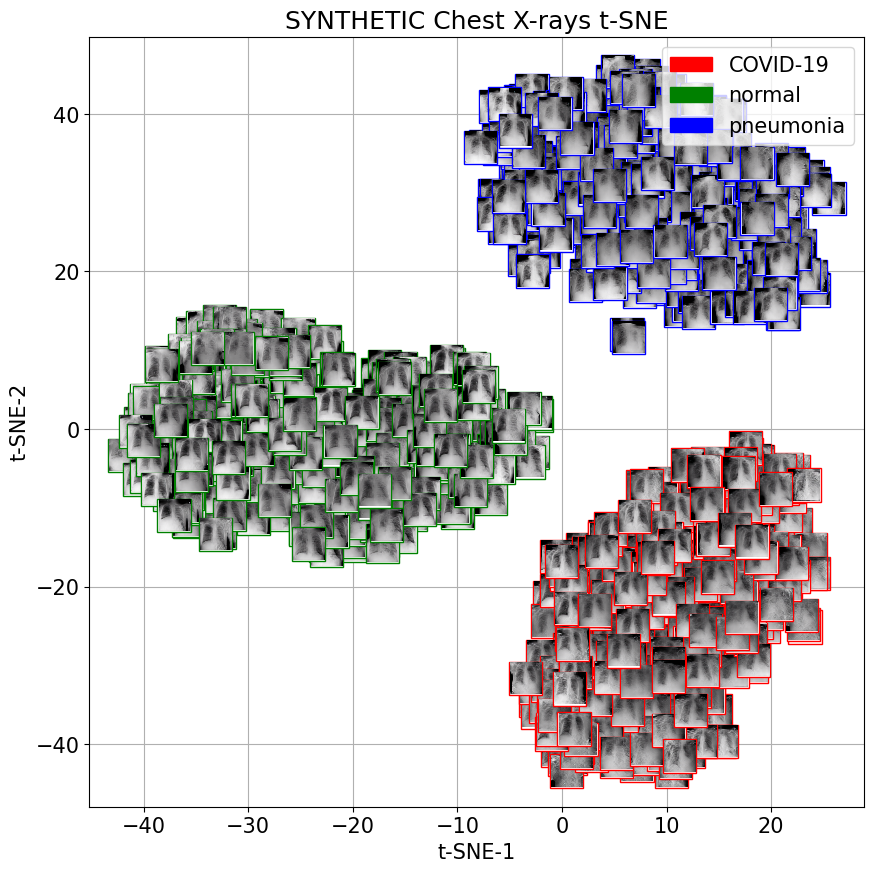

In [568]:
plt.rcParams["font.size"] = 15
scatter_plot_embedding(batch_size = batch_size_tSNE, synthetic = True, datagen = None)

In [498]:
tSNE_testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}-clean/train')

train_datagen = ImageDataGenerator()

tSNE_testing_data = train_datagen.flow_from_directory(tSNE_testing_path, batch_size = batch_size_tSNE, 
                                             target_size = (img_size, img_size),
                                             shuffle = True, class_mode = 'binary', seed = 42)
print(tSNE_testing_data.class_indices)

Found 7172 images belonging to 3 classes.
{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


In [212]:
len(tSNE_testing_data)

30

(1000, 18432)


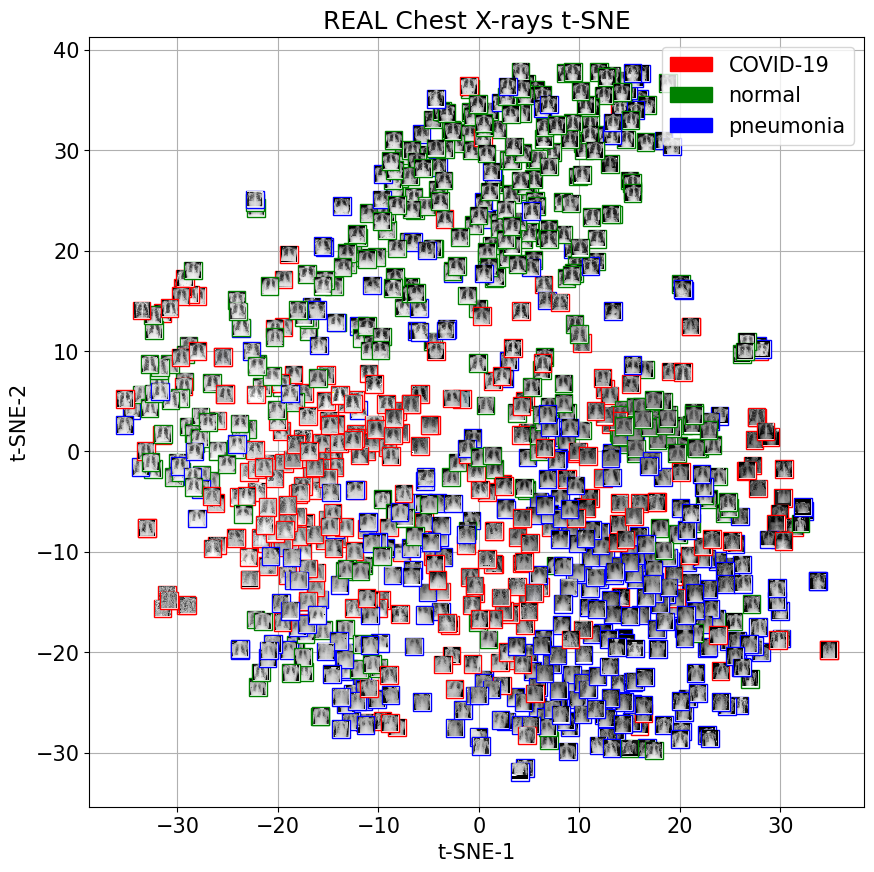

In [499]:
scatter_plot_embedding(batch_size = batch_size_tSNE, 
             synthetic = False, 
             datagen = tSNE_testing_data)

### t-SNE 2

In [584]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.offsetbox as offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
plt.rcParams["font.size"] = 15

def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)
    
def visualize_scatter_with_images(X_2d_data, images, labels, 
                                  title, figsize=(10,10), image_zoom=0.1):
    name_map = {0:'COVID-19', 1:'normal', 2:'pneumonia'}
    color_map = {0:'red', 1:'green', 2:'blue'}
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid()
    artists = []
    unique_labels = np.unique(labels)
    #print(unique_labels)
    cmap = plt.get_cmap("jet")
    
    for xy, i, label in zip(X_2d_data, images, labels):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=True, pad = 0.05,
                            bboxprops =dict(edgecolor=color_map[label], clip_on = False))
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    
    patch_list = []
    for label in unique_labels:
        patch = mpatches.Patch(color=color_map[label], label=str(name_map[label]))
        patch_list.append(patch)
    plt.legend(handles=patch_list)
    
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    plt.title(title)
    plt.show()

   
def visualize_scatter(data_2d, label_ids, figsize=(8,8), legend=True,title="None"):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    print(nb_classes)
    colors = cm.rainbow(np.linspace(0, 1, nb_classes))
    print(colors)
    
    for i,label_id in enumerate(np.unique(label_ids)):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color=colors[i],
                    linewidth='1',
                    alpha=0.8,
                    label=label_id)
    print("ok")
    if legend:
        plt.legend()
    else:
        # plt.title(title)
        plt.axis('off')
    print("ok")
    plt.show()

def scatter_plot(plot_img=True,
                legend=True, 
                batch_size = 1000, synthetic = True, datagen = None):
    
    ### IMAGES FOR RECTANGLE ###
    # Generate images and labels and normalize them to [0, 255]
    
    
    title="SYNTHETIC Chest X-rays t-SNE"
    noise, labels = generate_batch_noise_and_labels(batch_size = batch_size, 
                                                latent_dim = 100)
    
    images_batch = generator_instance.predict([noise, labels.reshape((-1, 1))], 
                                                    verbose=0)
    images_batch = cv2.normalize((images_batch + 1) * 127.5, 
                                    None, alpha=0, beta=255, 
                                    norm_type=cv2.NORM_MINMAX, 
                                    dtype=cv2.CV_32F)
    images_batch = images_batch.astype(np.uint8)
        
    print(images_batch.shape)
    
    title="REAL Chest X-rays t-SNE"
    images_batch_real, labels_real = datagen[3]
    images_batch_real = images_batch_real.astype(np.uint8)
    
    print(images_batch_real.shape)
    
    images_batch = np.concatenate((images_batch, images_batch_real), axis=0)
    labels = np.concatenate((labels, labels_real), axis=0)
    ### TSNE ###
     
    # Reshape images for PCA and TSNE (data to plot)
    # but keep the original shape for the images to plot them inside the scatter plot
    
    print(images_batch.shape)
    
    print(labels.shape)
    images_tsne = images_batch.reshape(images_batch.shape[0], -1)
    print(images_tsne.shape)
    # PCA to reduce the dimensionality of the data and
    # improve the performance of the TSNE algorithm
    #pca = PCA(n_components=50)
    #images_tsne = pca.fit_transform(images_tsne)
    tsne = TSNE(n_components=2, random_state=0)
    images_tsne = tsne.fit_transform(images_tsne)
    print(images_tsne.shape)
    # Firstly i plot the images inside the scatter plot
    if plot_img:
        title="SYNTHETIC Chest X-rays t-SNE"
        visualize_scatter_with_images(images_tsne[:batch_size], 
                                      images_batch[:batch_size], 
                                      labels[:batch_size], title)
        title="REAL Chest X-rays t-SNE"
        visualize_scatter_with_images(images_tsne[batch_size:],
                                      images_batch[batch_size:], 
                                      labels[batch_size:], title)
        #print(labels)
        #visualize_scatter(images_tsne, labels, legend=legend,title=title)    
        
def scatter_plot_embedding(plot_img=True,
                legend=True, 
                batch_size = 1000, synthetic = True, datagen = None):
    
    ### IMAGES FOR RECTANGLE ###
    # Generate images and labels and normalize them to [0, 255]
    
    
    title="SYNTHETIC Chest X-rays t-SNE"
    noise, labels = generate_batch_noise_and_labels(batch_size = batch_size, 
                                                latent_dim = 100)
    
    images_batch = generator_instance.predict([noise, labels.reshape((-1, 1))], 
                                                    verbose=0)
    images_batch = cv2.normalize((images_batch + 1) * 127.5, 
                                    None, alpha=0, beta=255, 
                                    norm_type=cv2.NORM_MINMAX, 
                                    dtype=cv2.CV_32F)
    images_batch = images_batch.astype(np.uint8)
        
    print(images_batch.shape)
    
    title="REAL Chest X-rays t-SNE"
    images_batch_real, labels_real = datagen[3]
    images_batch_real = images_batch_real.astype(np.uint8)
    
    print(images_batch_real.shape)
    
    images_batch = np.concatenate((images_batch, images_batch_real), axis=0)
    labels = np.concatenate((labels, labels_real), axis=0)
    ### TSNE ###
     
    # Reshape images for PCA and TSNE (data to plot)
    # but keep the original shape for the images to plot them inside the scatter plot
    
    print(images_batch.shape)
    
    print(labels.shape)
    images_tsne = feature_extractor_class.predict(images_batch)
    #images_tsne = images_batch.reshape(images_batch.shape[0], -1)
    print(images_tsne.shape)
    # PCA to reduce the dimensionality of the data and
    # improve the performance of the TSNE algorithm
    pca = PCA(n_components=50)
    images_tsne = pca.fit_transform(images_tsne)
    tsne = TSNE(n_components=2, random_state=0)
    images_tsne = tsne.fit_transform(images_tsne)
    print(images_tsne.shape)
    # Firstly i plot the images inside the scatter plot
    if plot_img:
        title="SYNTHETIC Chest X-rays t-SNE"
        visualize_scatter_with_images(images_tsne[:batch_size], 
                                      images_batch[:batch_size], 
                                      labels[:batch_size], title)
        title="REAL Chest X-rays t-SNE"
        visualize_scatter_with_images(images_tsne[batch_size:],
                                      images_batch[batch_size:], 
                                      labels[batch_size:], title)
        #print(labels)
        #visualize_scatter(images_tsne, labels, legend=legend,title=title)    

In [546]:
batch_size_tSNE = 1000

In [ ]:
# plt.rcParams["font.size"] = 15
# scatter_plot(batch_size = batch_size_tSNE, synthetic = True, datagen = None)

In [ ]:
tSNE_testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}-clean/train')

#tSNE_testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/train')

train_datagen = ImageDataGenerator()

tSNE_testing_data = train_datagen.flow_from_directory(tSNE_testing_path, batch_size = batch_size_tSNE, 
                                             target_size = (img_size, img_size),
                                             shuffle = True, class_mode = 'binary', seed = 42)
print(tSNE_testing_data.class_indices)

Found 7172 images belonging to 3 classes.
{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


In [370]:
len(tSNE_testing_data)

30

(1000, 112, 112, 3)
(1000, 112, 112, 3)
(2000, 112, 112, 3)
(2000,)
63/63 [==============================] - 0s 3ms/step
(2000, 18432)
(2000, 2)


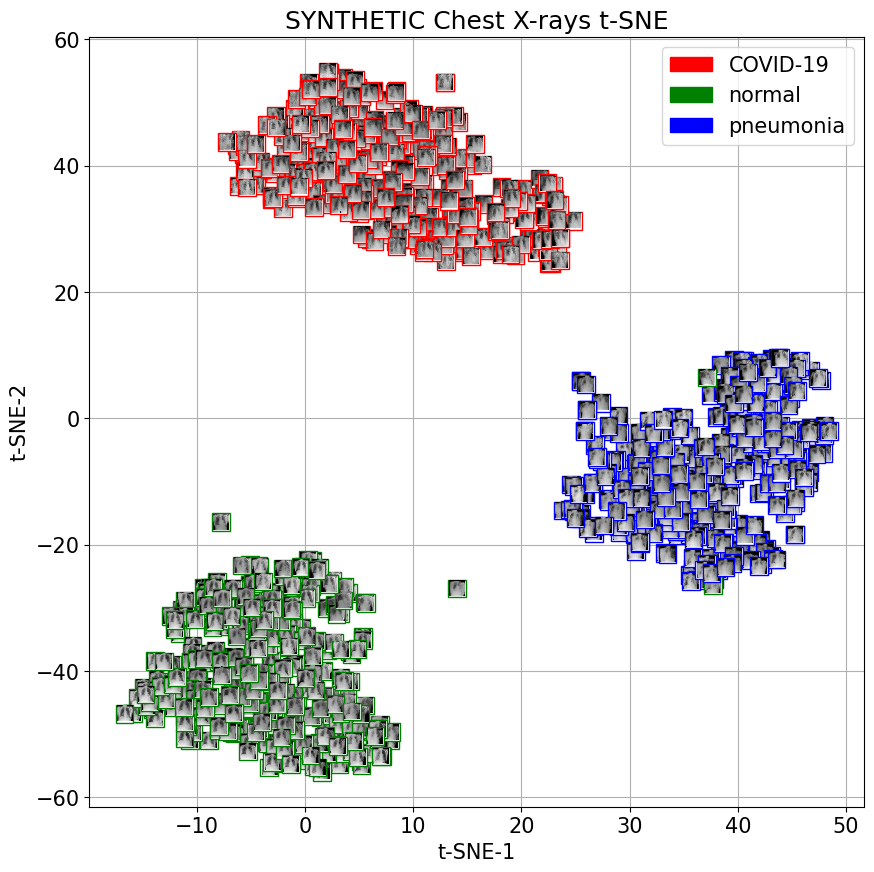

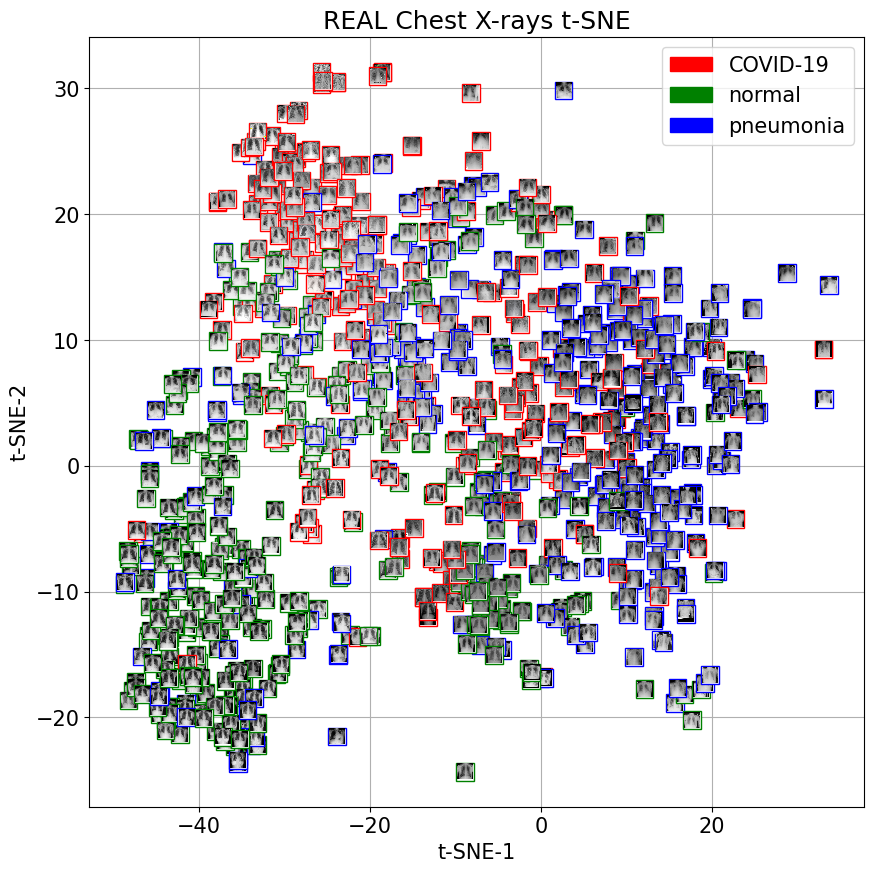

In [586]:
scatter_plot_embedding(batch_size = batch_size_tSNE, 
             synthetic = False, 
             datagen = tSNE_testing_data)

## GIF

In [21]:
# Impostare la directory contenente le immagini
img_folder = "./SaveDir/images_for_gif"
save_folder = "./SaveDir/animated_gif"

best_epoch = "image_at_epoch_0288.png"

# Impostare il nome del file gif da generare
gif_filename = f"{save_folder}/animated_t1.gif"

In [22]:
from PIL import Image, ImageDraw, ImageFont
import os
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Impostare il font da utilizzare per il testo "Epoch"
font = ImageFont.truetype("arial.ttf", 36)

# Impostare la durata di ciascun frame (in millisecondi)
frame_duration = 500

# Impostare il numero di frame da includere nella GIF
frame_step = 2

# Trova tutti i file png nella cartella
png_files = [f for f in os.listdir(img_folder) if f.endswith(".png")]

# Ordina i file png in base al loro numero epoch
png_files = sorted(png_files, key=lambda f: int(f.split("_")[3].split('.')[0]))

# Inizializza una lista per contenere tutti i frame della GIF
frames = []

# Itera sui file png, prendendo un file ogni frame_step
for i, png_file in enumerate(png_files[::frame_step]):
    # Apri l'immagine
    img = Image.open(os.path.join(img_folder, png_file))

    # Estrai il numero epoch dal nome del file
    epoch_number = int(png_file.split("_")[3].split('.')[0])

    # Calcola la posizione del testo "Epoch" in base alla dimensione dell'immagine
    
    
    # Aggiungi il testo "Epoch" con il numero epoch sopra l'immagine
    draw = ImageDraw.Draw(img)
    
    text = f"Epoch {epoch_number}"
    text_width, text_height = draw.textsize(text, font)
    x = (img.width - text_width) / 2
    text_position = (x, 10)
    
    draw.text(text_position, text, font=font, fill=(0, 0, 0))


    # Aggiungi il frame alla lista dei frame della GIF
    frames.append(img)
    
# Final frame

img = Image.open(os.path.join(img_folder, best_epoch))
# Estrai il numero epoch dal nome del file
epoch_number = int(best_epoch.split("_")[3].split('.')[0])
# Aggiungi il testo "Epoch" con il numero epoch sopra l'immagine
draw = ImageDraw.Draw(img)
# Properties
text = f"Epoch {epoch_number}"
text_width, text_height = draw.textsize(text, font)
x = (img.width - text_width) / 2
text_position = (x, 10)
# Write
draw.text(text_position, text, font=font, fill=(0, 0, 0))
# Aggiungi il frame alla lista dei frame della GIF
frames.append(img)

# Salva i frame come GIF
frames[0].save(
    gif_filename,
    save_all=True,
    append_images=frames[1:],
    duration=frame_duration,
    #loop=1,
)

# Visualize Model

In [68]:
def discriminator(input_shape=(112, 112, 3), n_classes = 3):
    # Define the weight initialization method
    # init = RandomNormal(mean = 0.0, stddev = 0.02)
    
    # Define the convolutional block to be used multiple times
    def conv_block(input_layer, filter_size, stride):
        # Apply Conv2D with specified filter size, kernel size, padding, strides and weight initialization
        x = Conv2D(filter_size, kernel_size = (3,3), padding='same', 
                   strides=stride, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_layer)
        # Apply BatchNormalization with momentum = 0.9
        x = BatchNormalization(momentum = 0.9)(x)
        # Apply LeakyReLU activation with alpha = 0.2
        x = LeakyReLU(alpha = 0.2)(x)
        # Apply dropout with rate 0.5
        x = Dropout(0.5)(x)
        # Return the result
        return x
    
    # Input layer for image
    input_img = Input(shape=input_shape)
    
    # Apply Conv2D with 32 filters, kernel size (3, 3), strides (1, 1), padding 'same' and weight initialization
    x = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), padding='same', 
               kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_img)
    # Apply BatchNormalization with momentum = 0.9
    x = BatchNormalization(momentum = 0.9)(x)
    # Apply LeakyReLU activation with alpha = 0.2
    x = LeakyReLU(alpha = 0.2)(x)
    # Apply dropout with rate 0.5
    x = Dropout(0.5)(x)

    # Downsample the image to 56 x 56 x 64 using the conv_block
    x = conv_block(x, 64, (2, 2))
    # Downsample the image to 28 x 28 x 128 using the conv_block
    x = conv_block(x, 128, (2, 2))

    # Downsample the image to 14 x 14 x 256 using the conv_block
    x = conv_block(x, 256, (2, 2))
    # Downsample the image to 7 x 7 x 512 using the conv_block
    x = conv_block(x, 512, (2, 2))
    
    # Flatten the final layer
    features = Flatten()(x)

    # Binary classifier to classify image as fake or real
    fake = Dense(1, activation='sigmoid', name='source')(features)

    # Multi-class classifier to classify image digit
    aux = Dense(n_classes, activation='softmax', name='auxiliary')(features)

    # Create the final model
    # Model has two outputs - fake (binary fake/real prediction) and aux (multi-class digit prediction)
    model = Model(inputs = input_img,  outputs = [fake, aux])

    # Return the model
    return model

In [69]:
d = discriminator(input_shape=(112, 112, 3))

In [65]:
d.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 56, 56, 64)   1792        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 56, 56, 64)  256         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [28]:
d.save("./full_models/discriminator_layers_only.h5", include_optimizer=False)

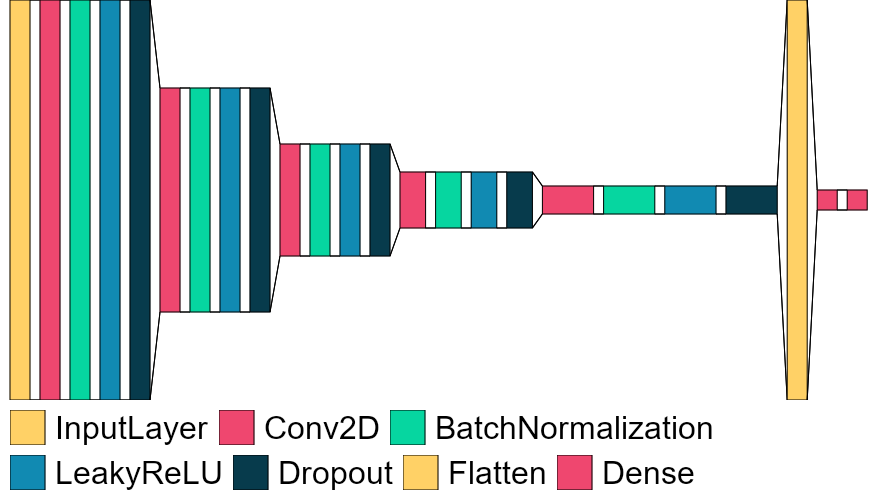

In [49]:
font = ImageFont.truetype("arial.ttf", 32)
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(d, legend = True, max_xy = 400, one_dim_orientation='y', draw_volume=False, font = font)


In [56]:
def generator(latent_dim = 100, n_classes = 3):
    # Initialize RandomNormal with mean = 0.0 and stddev = 0.02
    # init = RandomNormal(mean = 0.0, stddev = 0.02)
  
    ### Input 1: class label input ###
    
    # Generator take integer class label as input
    label_input = Input(shape = (1,))
    # print(label_input.shape)
    
    # Embedding layer: to convert class label integer to a vector of size 100
    y = Embedding(n_classes, 100)(label_input)
    # print('Embedding Layer: ', y.shape)
    
    # Dense layer with 7 x 7 units: to convert the vector to a 7 x 7 x 1 tensor
    n_nodes = 7 * 7
    y = Dense(n_nodes, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(y)
    # print('Dense 1: ', y.shape)
    y = Reshape((7, 7 ,1))(y)
    print('reshape(final y shape): ', y.shape)

    ### Input 2: generator noise input ###
    
    # A latent_dim-dimensional vector is sampled from a normal distribution
    # with mean = 0.0 and stddev = 0.02 
    generator_input = Input(shape = (latent_dim,))
    
    # Noise vector is passed through a dense layer with 1024 * 7 * 7 units 
    # to produce a 7 x 7 x 1024 tensor
    n_nodes = 1024 * 7 * 7
    gen = Dense(n_nodes, 
                kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(generator_input)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 1024))(gen)
    print('Generator noise input: ', gen.shape)
    
    ### Concatenate both the inputs ###
    # The output tensors are then concatenated to produce a 7 × 7 × 1025 tensor. 
    merge = Concatenate()([gen, y])
    print('Concatenate(generator noise input and y: ', merge.shape)

    ### Upsampling ###
    # four successive transposed convolutions 
    # to produce tensors with dimensions 14 × 14 × 512, 28 × 28 × 256, 56 × 56 × 128 and 128 × 128 × 3, respectively.
    
    # (None, 7, 7, 1024) --> (None, 14, 14, 512)
    gen = Conv2DTranspose(512, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(merge)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print("(None, 7, 7, 1024) -> (None, 14, 14, 512): ", gen.shape)

    # (None, 14, 14, 512)  --> (None, 28, 28, 256)
    gen = Conv2DTranspose(256, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 14, 14, 512) -> (None, 28, 28, 256): ', gen.shape)

    # (None, 28, 28, 256) --> (None, 56, 56, 128)
    gen = Conv2DTranspose(128, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 28, 28, 256) -> (None, 56, 56, 128): ', gen.shape)

    # (None, 56, 56, 128) --> (None, 112, 112, 3)
    gen = Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    out_layer = Activation("tanh")(gen)
    print("(None, 56, 56, 128) -> (None, 112, 112, 3): ", out_layer.shape)
    
    # The final output from the generator is an fake image X of dimension 112 × 112 × 3
    model = Model(inputs = [generator_input, label_input], outputs = out_layer)
    return model

In [57]:
g = generator()

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)


In [59]:
visualkeras.layered_view(g)

TypeError: 'int' object is not iterable

# Tests

## Normalization

### Imported Images

When imported, images are:

In [176]:
batchx, batchy = test_data.next()
print(batchx.min())
print(batchx.max())

0
255.0


Scale [-1;+1]

In [26]:
# First way (best way)
print(((batchx - 127.5)/127.5).min())
print(((batchx - 127.5)/127.5).max())
# Second way
cv2.normalize(batchx, 
              None, alpha=-1, beta=+1, 
              norm_type=cv2.NORM_MINMAX, 
              dtype=cv2.CV_32F)


-1.0
1.0


Scale [0;+1]

In [ ]:
# First way (best way)
print((batchx / 255.).min())
print((batchx / 255.).max())
# Second way
cv2.normalize((batchx + 1) * 127.5, 
              None, alpha=0, beta=1, 
              norm_type=cv2.NORM_MINMAX, 
              dtype=cv2.CV_32F)

### Generated Images

Images are generated in [-1,~+1]

In [24]:
noise_gen, sampled_labels_gen = generate_batch_noise_and_labels(batch_size=62, latent_dim=100)
generated_images_sample = generator_instance.predict([noise_gen, sampled_labels_gen.reshape((-1, 1))], verbose=0)
print(generated_images_sample.min())
print(generated_images_sample.max())

-1.0
0.9306434


Normalize to [-1,+1]

In [ ]:
cv2.normalize(generated_images_sample, 
              None, alpha=-1, beta=+1, 
              norm_type=cv2.NORM_MINMAX, 
              dtype=cv2.CV_32F)

Conversion to [0;255]

In [ ]:
# Firstly with + 1 and * 127.5 we scale to [0, ~255]
# Then with cv2.normalize we scale to [0, 255] (uint8)
norm_image = cv2.normalize((generated_images_sample + 1) * 127.5, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
norm_img = norm_image.astype(np.uint8)

Normalize to [0;1]

In [ ]:
# First we scale to [0, ~1]
generated_images_sample = (generated_images_sample + 1) / 2
# Then we scale to [0, 1]
generated_images_sample = cv2.normalize(generated_images_sample, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
